In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os



import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox



from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX


# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor


from scipy import signal
from scipy import stats

sys.path.append("..")
from eda_utilities import print_eda_stats
from data_pipeline import dockless_data_pipeline
from data_pipeline import weather_data_pipeline

In [12]:
# Read the dockless data from S3 bucket
# Load the data and and call the clean method automatically to call the work flow
dockless_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Dockless_Vehicle_Trips.csv")
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")
# Call the dockless_data_pipeline()
dockless_data_pipeline(dockless_data)
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


+--------------------------+---------+-------------+---------------+--------------+-------------------+
|       Column Name        |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+--------------------------+---------+-------------+---------------+--------------+-------------------+
|            ID            |  object |   2746505   |    2746505    |   2746505    |         0         |
|        Device ID         |  object |   2746505   |     26999     |   2746505    |         0         |
|       Vehicle Type       |  object |   2746504   |       3       |   2746505    |         1         |
|      Trip Duration       | float64 |   2746504   |     10521     |   2746505    |         1         |
|      Trip Distance       | float64 |   2746504   |     16125     |   2746505    |         1         |
|        Start Time        |  object |   2746504   |     25694     |   2746505    |         1         |
|         End Time         |  object |   2746504   |     25768  

In [3]:
#Read the weather data from S3 bucket
weather_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Bergstom_Airport_Weather.csv")
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")
weather_data_pipeline(weather_data)
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")

+-----------------+---------+-------------+---------------+--------------+-------------------+
|   Column Name   |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+-----------------+---------+-------------+---------------+--------------+-------------------+
|     STATION     |  object |     436     |       1       |     436      |         0         |
|       NAME      |  object |     436     |       1       |     436      |         0         |
|     LATITUDE    | float64 |     436     |       1       |     436      |         0         |
|    LONGITUDE    | float64 |     436     |       1       |     436      |         0         |
|    ELEVATION    | float64 |     436     |       1       |     436      |         0         |
|       DATE      |  object |     436     |      436      |     436      |         0         |
|       AWND      | float64 |     435     |       73      |     436      |         1         |
| AWND_ATTRIBUTES |  object |     435     |       

In [14]:
# TODO : Add to pipeline
# Drop all records where  trip distance is less .1 miles and greater than 500 miles (1609.34 mts - 804673 mts)
dockless_data = dockless_data[(dockless_data['Trip Distance'] > 1609.34) & (dockless_data['Trip Distance'] < 804673)]
dockless_data = dockless_data[(dockless_data['Trip Duration'] > 60) & (dockless_data['Trip Duration'] < 86400)]


In [15]:
# TODO : Add to pipeline
# Have only weather data which is from the start date of the scooter data
trip_counts = dockless_data.groupby('START_DATE').count()['count']
weather_data= weather_data[weather_data['DATE'] >= trip_counts.index.min()]
weather_data= weather_data[weather_data['DATE'] <= trip_counts.index.max()]
weather_data = weather_data.reset_index()

In [17]:
# TODO : Add to pipeline


def find_top_group_by_column_list(data, group_by_column, sort_by_column, agg_column, n=10):
    grouped_origin_cell_id = data.groupby([group_by_column]).agg(agg_column)
    grouped_origin_cell_id = grouped_origin_cell_id.sort_values([sort_by_column], ascending=False)
    top_origin_cell_ids = grouped_origin_cell_id[sort_by_column]
    # Rename the column Trip Duration to Trip Counts
    top_origin_cell_ids = top_origin_cell_ids.to_frame().reset_index()
    top_50_origin_cells = top_origin_cell_ids.head(n)
    #top_50_origin_cells.to_csv("../../output/EDA/Top_50_Origin_Cells_Total_Rides.csv")
    top_10_origin_cells = top_50_origin_cells[0:n]
    top_10_origin_cells = top_10_origin_cells[group_by_column].values
    top_10_origin_cells_list = top_10_origin_cells.tolist()
    return top_10_origin_cells_list
    

top_10_origin_cell = find_top_group_by_column_list(dockless_data, 'Origin Cell ID', 'Trip Duration', 'count', n=10)

In [23]:
# Top 3 origin cell data
# cell_014706_data = dockless_data[dockless_data['Origin Cell ID'] == '014706']
# cell_013650_data = dockless_data[dockless_data['Origin Cell ID'] == '013650']
# cell_013176_data = dockless_data[dockless_data['Origin Cell ID'] == '013176']

In [19]:
len(dockless_data['Start Time'].unique())

23622

In [20]:
dockless_data.shape

(688246, 19)

In [22]:
df2 = dockless_data
df2 = df2.reset_index()
df2 = df2.set_index("Start Time")
df2.shape

(688246, 19)

In [ ]:
# TODO: Add to the pipeline

# All dockless_data is sent as data parameters
def aggregrate_data_for_analysis(data, cell_id_list):
    origin_cell_data = data[['Origin Cell ID', 'Start Time' 'count']]
    origin_cell_id_data = origin_cell_data[origin_cell_data['Origin Cell ID'].isin(cell_id_list)]
    
cell_id_list = top_10_origin_cell[0:3]


In [79]:
origin_cell_data = df2[['Origin Cell ID', 'count']]
cell_014706_data = origin_cell_data[origin_cell_data['Origin Cell ID'] == '014706']
cell_014391_data = origin_cell_data[origin_cell_data['Origin Cell ID'] == '014391']
cell_014705_data = origin_cell_data[origin_cell_data['Origin Cell ID'] == '014705']

cell_014391_data.shape

(9038, 2)

In [66]:
trip_counts_cell_014706 = cell_014706_data.groupby([cell_014706_data.index.get_level_values(0),'Origin Cell ID']).count()
trip_counts_cell_014706 = trip_counts_cell_014706.unstack(level=1)
trip_counts_cell_014706 = trip_counts_cell_014706.fillna(0)

# Make a regular dataframe for processing the Time Series
t2 = trip_counts_cell_014706.reset_index()['count']
counts = t2['014706'].values
data = {'Start Time':trip_counts_cell_014706.index.values, '014706':counts} 
trip_counts_cell_014706_new = pd.DataFrame(data)
data_014706 = trip_counts_cell_014706_new.set_index("Start Time")
#data_014706 = data_014706[(data_014706.index > '2018-07-15')]
data_014706.head(10)

,014706
Start Time,
2018-04-06 08:45:00,1
2018-04-08 13:00:00,1
2018-04-08 15:00:00,2
2018-04-09 14:30:00,1
2018-04-09 16:00:00,1
2018-04-09 17:00:00,1
2018-04-10 12:30:00,3
2018-04-10 12:45:00,1
2018-04-10 14:45:00,1


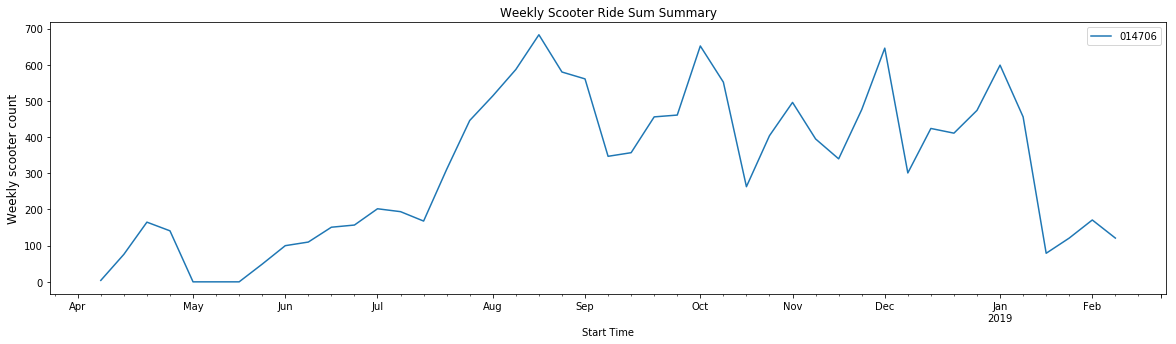

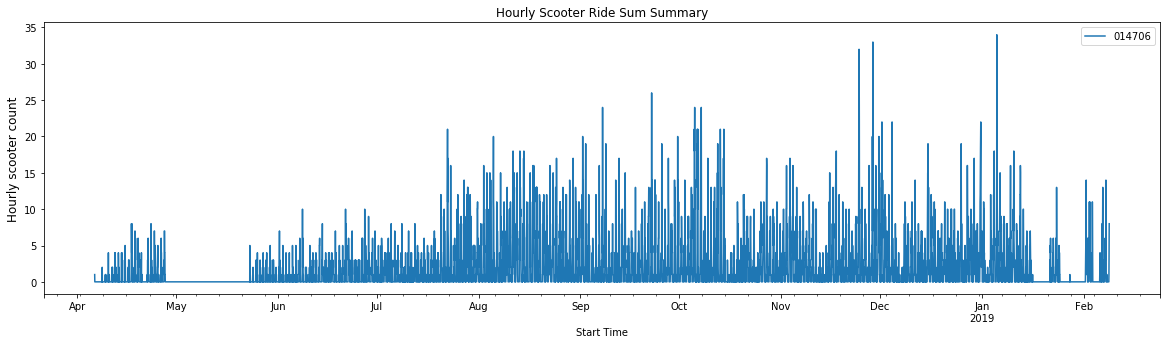

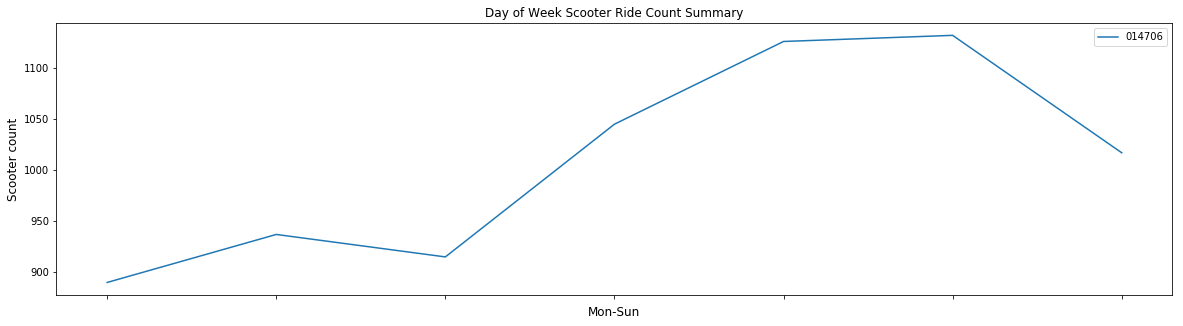

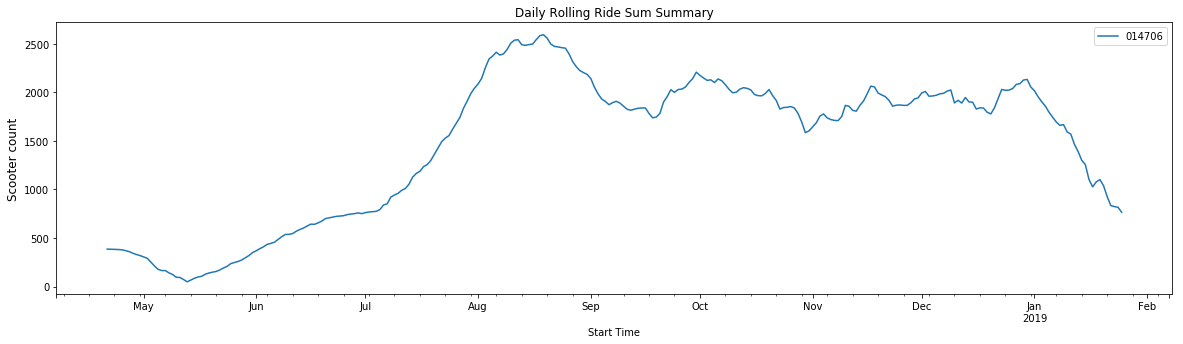

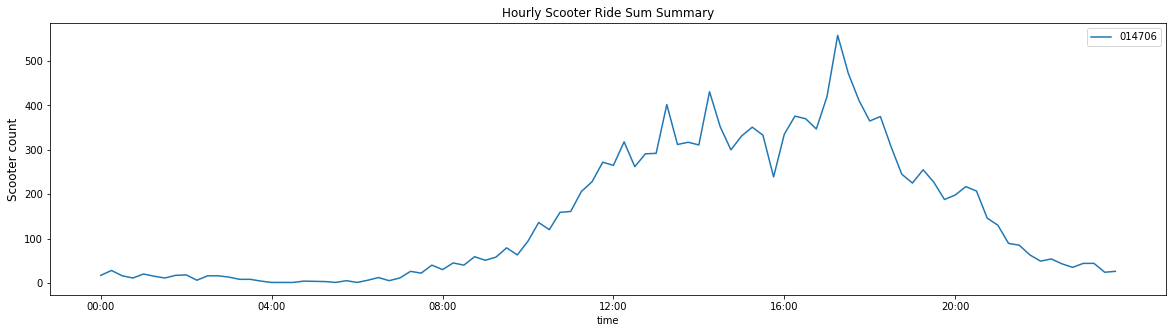

In [67]:
# Run all analysis on 014706

weekly = data_014706.resample('W').sum()
weekly.plot(style=['-', '--', ':'],figsize=(20, 5))
plt.title('Weekly Scooter Ride Sum Summary')
plt.ylabel('Weekly scooter count', fontsize=12)
plt.savefig('../../output/EDA/Top/Weekly_Scooter_014706.png')

hourly = data_014706.resample('H').sum()
hourly.plot(style=['-', '--', ':'],figsize=(20, 5))
plt.title('Hourly Scooter Ride Sum Summary')
plt.ylabel('Hourly scooter count', fontsize=12)
plt.savefig('../../output/EDA/Top/Hourly_Scooter_014706.png')

by_weekday = data_014706.groupby(data_014706.index.dayofweek).count()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=['-', '--', ':'],figsize=(20, 5));
plt.title('Day of Week Scooter Ride Count Summary')
plt.ylabel('Scooter count', fontsize=12)
plt.xlabel('Mon-Sun', fontsize=12,rotation='horizontal')
plt.savefig('../../output/EDA/Top/Day_of_Week_Scooter_014706.png')

daily = data_014706.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=['-', '--', ':'],figsize=(20, 5))
plt.title('Daily Rolling Ride Sum Summary')
plt.ylabel('Scooter count', fontsize=12)
plt.savefig('../../output/EDA/Top/Daily_Rolling_30_Scooter_014706.png')


by_time = data_014706.groupby(data_014706.index.time).sum()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=['-', '--', ':'],figsize=(20, 5));
plt.title('Hourly Scooter Ride Sum Summary')
plt.ylabel('Scooter count', fontsize=12)
plt.savefig('../../output/EDA/Top/Hour_Count_Scooter_014706.png')
plt.show()

plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


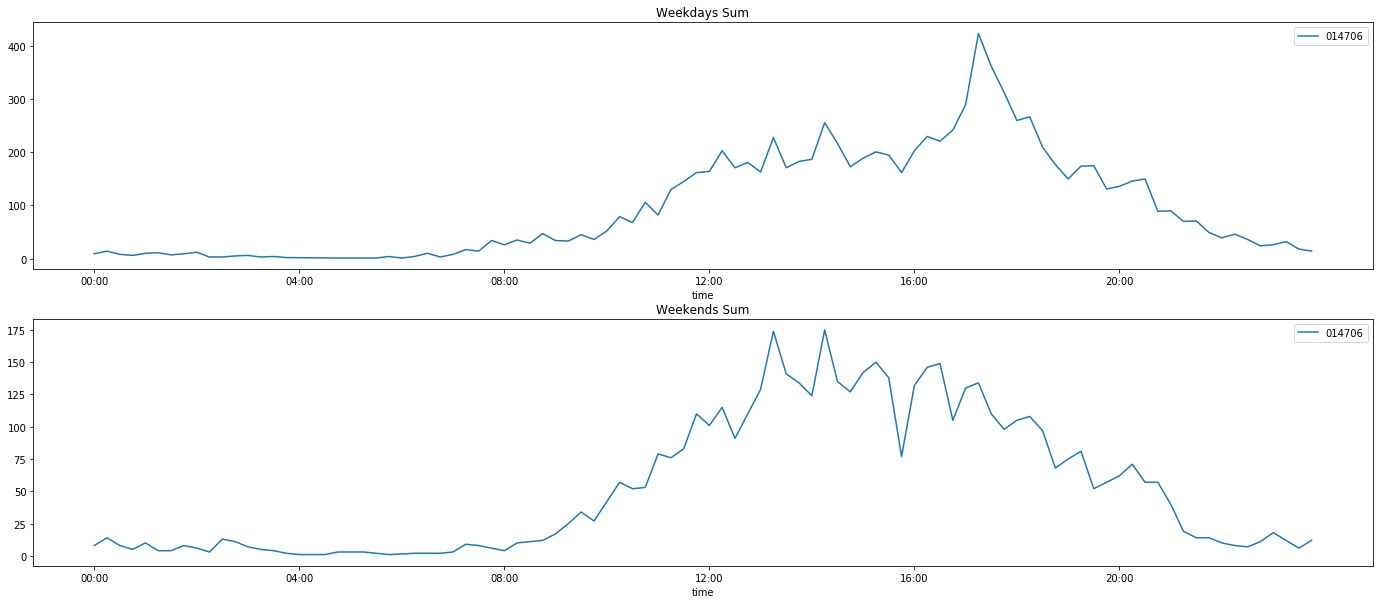

In [68]:
weekend = np.where(data_014706.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data_014706.groupby([weekend, data_014706.index.time]).sum()

fig, ax = plt.subplots(2, 1, figsize=(24, 10))
by_time.ix['Weekday'].plot(ax=ax[0], title='Weekdays Sum',
                           xticks=hourly_ticks, style=['-', '--', ':'])
by_time.ix['Weekend'].plot(ax=ax[1], title='Weekends Sum',
                           xticks=hourly_ticks, style=['-', '--', ':']);
plt.savefig('../../output/EDA/Top/Weekday_Weekend_Sum Scooter_014706.png')


plt.show()

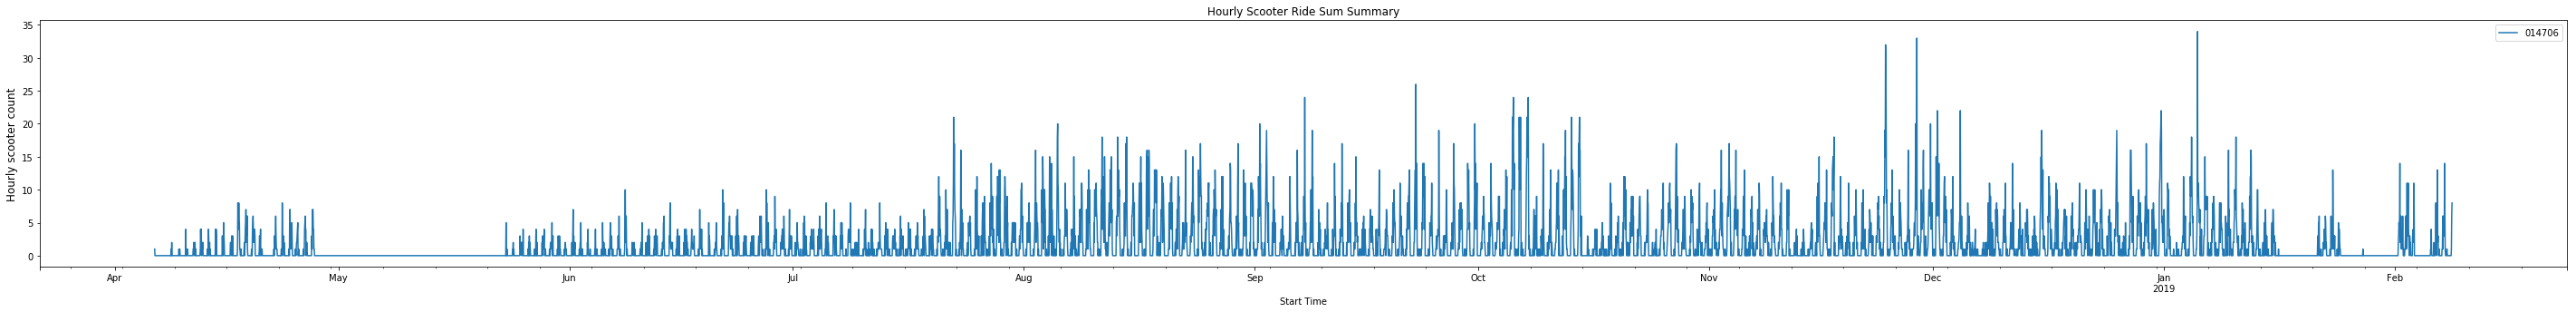

In [69]:
#Hourly expanded 

hourly = data_014706.resample('H').sum()
hourly.plot(style=['-', '--', ':'],figsize=(50, 5))
plt.title('Hourly Scooter Ride Sum Summary')
plt.ylabel('Hourly scooter count', fontsize=12)
plt.savefig('../../output/EDA/Top/Hourly_Scooter_014706_expanded.png')

In [75]:
trip_counts_cell_013650 = cell_013650_data.groupby([cell_013650_data.index.get_level_values(0),'Origin Cell ID']).count()
trip_counts_cell_013650

,,count
Start Time,Origin Cell ID,


In [81]:
trip_counts_cell_014391 = cell_014391_data.groupby([cell_014391_data.index.get_level_values(0),'Origin Cell ID']).count()
trip_counts_cell_014391 = trip_counts_cell_014391.unstack(level=1)
trip_counts_cell_014391 = trip_counts_cell_014391.fillna(0)

# Make a regular dataframe for processing the Time Series
t2 = trip_counts_cell_014391.reset_index()['count']
counts = t2['014391'].values
data = {'Start Time':trip_counts_cell_014391.index.values, '014391':counts} 
trip_counts_cell_014391_new = pd.DataFrame(data)
data_014391 = trip_counts_cell_014391_new.set_index("Start Time")
#data_014706 = data_014706[(data_014706.index > '2018-07-15')]
data_014391.head(10)

,014391
Start Time,
2018-04-05 14:45:00,1
2018-04-06 13:15:00,2
2018-04-06 15:30:00,1
2018-04-06 15:45:00,1
2018-04-06 16:30:00,1
2018-04-06 17:30:00,1
2018-04-08 18:30:00,1
2018-04-08 18:45:00,1
2018-04-09 16:00:00,1


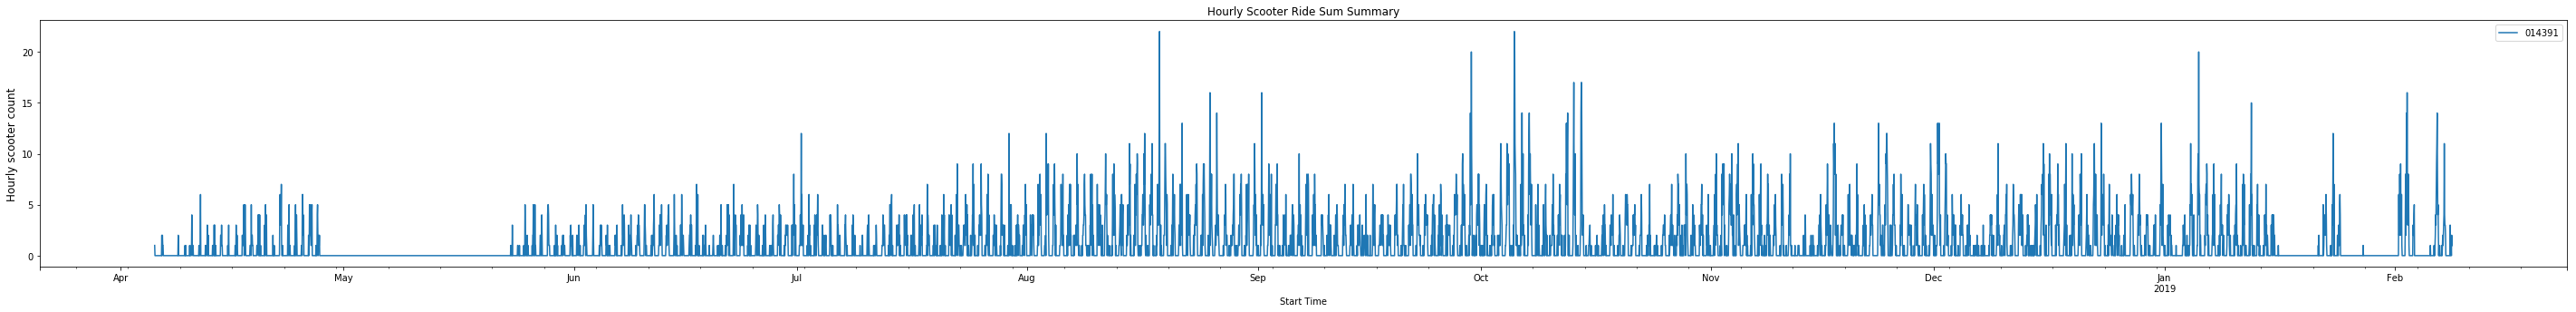

In [82]:
#Hourly expanded 

hourly = data_014391.resample('H').sum()
hourly.plot(style=['-', '--', ':'],figsize=(50, 5))
plt.title('Hourly Scooter Ride Sum Summary')
plt.ylabel('Hourly scooter count', fontsize=12)
plt.savefig('../../output/EDA/Top/Hourly_Scooter_014391_expanded.png')

##### After Jan 15th the data has lots of zero values so for the model the date range will be from July 15th - Jan 15th

In [84]:
# data after '2018-07-15' as the data is not consistent before that

data_014706 = data_014706[(data_014706.index > '2018-07-15')]
data_014706 = data_014706[(data_014706.index < '2019-01-15')]
data_014706.tail(5)

,014706
Start Time,
2019-01-14 18:15:00,1
2019-01-14 18:45:00,1
2019-01-14 20:15:00,2
2019-01-14 20:45:00,1
2019-01-14 21:00:00,1


In [85]:
# Resample with Sum
data_014706_hourly = data_014706.resample('H', how='sum')
data_014706_hourly = data_014706_hourly.fillna(0)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  


,014706
Start Time,
2018-07-15 00:00:00,1
2018-07-15 01:00:00,0
2018-07-15 02:00:00,0
2018-07-15 03:00:00,0
2018-07-15 04:00:00,0
2018-07-15 05:00:00,0
2018-07-15 06:00:00,0
2018-07-15 07:00:00,1
2018-07-15 08:00:00,0


In [86]:
# Add the following features to the data 
'''
Month, Day of the week(M,T, W, T, F, S, Sun), Weekday, Weekend, Week, Hour, Year, Max Temp, Precipitation, 
The day of the week with Monday=0, Sunday=6.
'''
data_014706_hourly['MONTH'] = pd.DatetimeIndex(data_014706_hourly.index).month
data_014706_hourly['YEAR'] = pd.DatetimeIndex(data_014706_hourly.index).year
data_014706_hourly['HOUR'] = pd.DatetimeIndex(data_014706_hourly.index).hour
data_014706_hourly['DAY'] = pd.DatetimeIndex(data_014706_hourly.index).day
data_014706_hourly['WEEK'] = pd.DatetimeIndex(data_014706_hourly.index).week
data_014706_hourly['DAY_OF_WEEK'] = pd.DatetimeIndex(data_014706_hourly.index).weekday
data_014706_hourly['WEEKEND'] = ((pd.DatetimeIndex(data_014706_hourly.index).weekday) // 5 == 1).astype(float)
data_014706_hourly['WEEKDAY'] = ((pd.DatetimeIndex(data_014706_hourly.index).weekday) // 5 == 0).astype(float)
data_014706_hourly['DATE'] = pd.DatetimeIndex(data_014706_hourly.index).date

In [168]:
# Merge the weather data into the hourly dataframe so you can add all the features
print(data_014706_hourly.shape)
merged_data_014706_hourly = pd.merge(left=data_014706_hourly,right=weather_data, how='left',left_on='DATE', right_on='DATE')
print(merged_data_014706_hourly.shape)
merged_data_014706_hourly = data_014706_hourly.reset_index().merge(weather_data, on='DATE', how="left").set_index('Start Time')

merged_data_014706_hourly.shape
data_014706_hourly.shape




(4414, 10)
(4414, 18)


(4414, 10)

In [105]:
# Create the test train split the same way as the univariate time series so this is the same as ARIMA series
size = int(len(merged_data_014706_hourly) * 0.66)
train, test = merged_data_014706_hourly[0:size], merged_data_014706_hourly[size:len(merged_data_014706_hourly)]
train = train.drop(['DATE', 'index', 'level_0'], axis=1)
test = test.drop(['DATE', 'index','level_0'], axis=1)
# train.pop('DATE')
# train.pop('index')
# test.pop('DATE')
# test.pop('index')

In [106]:
y_train = train.pop('014706').values
X_train = train.values
y_test = test.pop('014706').values
X_test = test.values


In [107]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    score = model.score(test_features, test_labels)
    print('Model Performance')
    print("Mean Square Error:", mean_squared_error(test_labels, predictions))
    print("Mean Absoulute Error:", mean_absolute_error(test_labels, predictions))
    print("Score:", score)
    return score

In [94]:
# Random Forest Best Model after grid search

# best_rf = RandomForestRegressor(bootstrap=True, max_depth=110, max_features=5, 
#                            min_samples_leaf=5, min_samples_split=12, n_estimators=100, random_state=0)

# best_rf.fit(X_train, y_train)
# base_accuracy = evaluate(best_rf, X_test, y_test)

Model Performance
Mean Square Error: 10.05096198625165
Mean Absoulute Error: 1.7854164214592756
Score: 0.4008086563318945


In [109]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 5, 7, 10, 13, 14],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


# Fit the grid search to the data
grid_search.fit(X_train, y_train)
#print("Grid Search Best Parameters:" grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Fitting 3 folds for each of 1008 candidates, totalling 3024 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.9s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   3.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   3.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   3.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3,

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.3s


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min

[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5

[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_

[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.8s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min

[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.5s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_

[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   3.7s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_s

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min


[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   4.6s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=7

[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=

[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.4s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=7

[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   6.7s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.5s
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.1s
[CV] bootstrap=True, max_depth=80, max_featu

[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   5.5s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   5.6s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   5.4s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_feat

[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   5.3s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   5.4s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_featu

[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_feat

[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_feat

[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_fe

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.4min


[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   5.8s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_fe

[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   6.9s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   6.7s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_featu

[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   6.8s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   6.9s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   6.6s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_feat

[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   6.3s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   6.4s
[CV] bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_featu

[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   3.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, m

[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, m

[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   3.0s
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV] bootstrap=True, max_depth=90, max_features=2, 

[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3,

[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3

[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.0s
[CV]  bootstrap=True, max_depth=90, max_features=

[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=5,

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.8min


[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=5, 

[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.8s
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=5

[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=

[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   4.6s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=7

[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   4.6s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=7,

[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.3s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.5s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.3s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=7, 

[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   5.6s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   5.7s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_featu

[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   6.6s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   6.5s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_feat

[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.1s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   6.4s
[CV] bootstrap=True, max_depth=90, max_featu

[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_fea

[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_fe

[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_f

[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_feat

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  6.0min


[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.1s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.1s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_feature

[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.2s
[CV] bootstrap=True, max_depth=90, max_features=

[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   7.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   6.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_feat

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.5s
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_featu

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_feature

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   3.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   3.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   4.1s
[CV] bootstrap=True, max_depth=100, max_featur

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_feature

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   4.5s
[CV] bootstrap=True, max_depth=100, max_features=

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_featur

[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.1s
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=100, max_fe

[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.8s
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_

[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   3.8s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.8s
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV] bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   5.3s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   5.0s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   4.9s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_feat

[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.3s
[CV] bootstrap=True, max_depth=100, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, 

[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  8.1min


[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   5.9s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=10

[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.8s
[CV] bootstrap=True, max_depth=100

[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   6.4s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   5.8s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100

[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   6.8s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   6.7s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=100, 

[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   7.4s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   7.4s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100,

[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   7.8s
[CV] bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=13, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   7.9s
[CV] bootstrap=True, max_depth=100, 

[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.4s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100,

[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.4s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.2s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100

[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=1

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   3.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=14, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   7.3s
[CV] bootstrap=True, max_depth=110, max_

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   3.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_f

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   3.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_fea

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   3.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   3.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_f

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   3.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   3.9s
[CV] bootstrap=True, max_depth=110, max_fe

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_featu

[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   3.3s
[CV] bootstrap=True, max_depth=110, max_featur

[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_feature

[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=5

[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 10.9min


[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   3.8s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.7s
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_f

[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   4.6s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   4.6s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   4.5s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   4.7s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   4.4s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.3s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=7, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   4.5s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.7s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110,

[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110,

[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=11

[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=11

[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   6.1s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=1

[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   6.3s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   5.9s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=110

[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   6.0s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=13, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   5.9s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=11

[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   6.7s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   6.5s
[CV] bootstrap=True, max_depth=110

[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   6.5s
[CV] bootstrap=True, max_depth=110, max_features=14, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110,

[Parallel(n_jobs=-1)]: Done 3024 out of 3024 | elapsed: 13.1min finished


Model Performance
Mean Square Error: 9.937553136012745
Mean Absoulute Error: 1.7582145476137605
Score: 0.4075695615518581


In [111]:
best_grid

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [113]:
best_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

best_rf.fit(X_train, y_train)
best_random_forest_accuracy = evaluate(best_rf, X_test, y_test)

Model Performance
Mean Square Error: 9.87718192397349
Mean Absoulute Error: 1.7513879886776977
Score: 0.4111686108478513


In [114]:
best_rf_predictions = best_rf.predict(X_test)

In [116]:
for i,j in  zip(train.columns.tolist(), best_rf.feature_importances_):
    print(i, ":", j)
    


MONTH : 0.015737124373219957
YEAR : 0.0
HOUR : 0.6971449784147891
DAY : 0.03775270354756452
WEEK : 0.036639745178525494
DAY_OF_WEEK : 0.05737909143379904
WEEKEND : 0.00679294276716528
WEEKDAY : 0.0065868434059743654
AVG_DAILY_WIND_SPEED : 0.029239139897934568
PRECIPITATION : 0.02343275992910248
SNOW : 0.0
AVG_TEMPERATURE : 0.027368091627555755
MAX_TEMPERATURE : 0.03960348865933137
MIN_TEMPERATURE : 0.02232309076503852


ADF p-value for 014706 series: 0.00
ADF p-value for differenced 014706 series: 0.00


(2913, 14)

In [110]:
# Pickle the dataframe
merged_data_014706_hourly.to_pickle("../../data/pickled_data/merged_data_014706_hourly.pkl")
dockless_data.to_pickle("../../data/pickled_data/dockless_data.pkl")
weather_data.to_pickle("../../data/pickled_data/weather_data.pkl")
data_014706.to_pickle("../../data/pickled_data/data_014706_hourly_count.pkl")

##### ARIMA Analysis

In [119]:
test = sm.tsa.stattools.adfuller(data_014706['014706'])
print("ADF p-value for 014706 series: {0:2.2f}".format(test[1]))
test = sm.tsa.stattools.adfuller(data_014706_hourly['014706'].diff()[1:])
print("ADF p-value for differenced 014706 series: {0:2.2f}".format(test[1]))


ADF p-value for 014706 series: 0.00
ADF p-value for differenced 014706 series: 0.00


##### MA Model

In [177]:
train_arima = y_train
data_014706.values

array([[1],
       [1],
       [1],
       ...,
       [2],
       [1],
       [1]])

In [189]:
# X = data_014706.values
# X = X.astype('float32')
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]

train_ma = y_train.astype('int')


history = [x for x in train_ma]
ma_predictions = list()
for t in range(len(y_test)):
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    ma_predictions.append(yhat)
    obs = y_test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
ma_error = mean_squared_error(y_test, ma_predictions)
print('MA Model MSE: %.3f' % ma_error)
# plot



# plt.plot(test)
# plt.plot(ma_predictions, color='red')
# plt.show()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:507: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MA Model MSE: 10.080


##### AR Model

In [212]:
# X = data_014706.values
# X = X.astype('float32')
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]

train_ar = y_train.astype('int')

history = [x for x in train_ar]
ar_predictions = list()
for t in range(len(y_test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    ar_predictions.append(yhat)
    obs = y_test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(y_test, ar_predictions)
print('AR Model MSE: %.3f' % error)
# plot
# plt.plot(test)
# plt.plot(ar_predictions, color='red')
# plt.show()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:507: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AR Model MSE: 10.077


##### SARIMA Model

In [ ]:
X = data_014706.values
X = X.astype('float32')
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

train_sar = y_train.astype('int')

history = [x for x in train_sar]
sarima_predictions = list()
for t in range(len(train_sar)):
    model = SARIMAX(endog=train_sar, order=(0,1,2), seasonal_order=(0,0,0,24))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    sarima_predictions.append(yhat)
    obs = y_test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(y_test, sarima_predictions)
print('Test MSE: %.3f' % error)
# plot
# plt.plot(test)
# plt.plot(sarima_predictions, color='red')
# plt.show()

In [125]:
y_test

array([0, 0, 0, ..., 0, 3, 1])

In [129]:
test.head(5)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [130]:
size = int(len(merged_data_014706_hourly) * 0.66)
train_1, test_1 = merged_data_014706_hourly[0:size], merged_data_014706_hourly[size:len(merged_data_014706_hourly)]

In [133]:
test_1.columns

Index(['014706', 'MONTH', 'YEAR', 'HOUR', 'DAY', 'WEEK', 'DAY_OF_WEEK',
       'WEEKEND', 'WEEKDAY', 'DATE', 'level_0', 'index',
       'AVG_DAILY_WIND_SPEED', 'PRECIPITATION', 'SNOW', 'AVG_TEMPERATURE',
       'MAX_TEMPERATURE', 'MIN_TEMPERATURE'],
      dtype='object')

In [134]:
test_results = test_1.drop(['MONTH', 'YEAR', 'HOUR', 'DAY', 'WEEK', 'DAY_OF_WEEK',
       'WEEKEND', 'WEEKDAY', 'DATE', 'level_0', 'index',
       'AVG_DAILY_WIND_SPEED', 'PRECIPITATION', 'SNOW', 'AVG_TEMPERATURE',
       'MAX_TEMPERATURE', 'MIN_TEMPERATURE'], axis=1)

In [136]:
test_results.rename(columns=dict(zip(["014706"], ["Actual"])), inplace=True)

In [157]:
test_results.head()

,Actual,ar_predictions
Start Time,,
2018-11-13 09:00:00,0,NaN
2018-11-13 10:00:00,0,NaN
2018-11-13 11:00:00,0,NaN
2018-11-13 12:00:00,2,NaN
2018-11-13 13:00:00,0,NaN


In [180]:
type(ma_predictions[0])

numpy.ndarray

In [139]:
#test_results['ar_predictions'] = pd.Series(ar_predictions)

In [141]:
ar_prediction

[array([1.33509221]),
 array([1.39991232]),
 array([1.66538165]),
 array([2.40051651]),
 array([1.86615381]),
 array([1.67014789]),
 array([1.00000003]),
 array([0.99999999]),
 array([1.4000546]),
 array([1.26550453]),
 array([2.13478791]),
 array([1.53162801]),
 array([1.66987882]),
 array([0.99999999]),
 array([1.00000001]),
 array([0.99999996]),
 array([1.39989609]),
 array([2.06576027]),
 array([2.26621027]),
 array([2.33529468]),
 array([2.00050378]),
 array([1.60046053]),
 array([1.33474121]),
 array([1.80006161]),
 array([3.1328305]),
 array([3.13133454]),
 array([2.60492164]),
 array([2.13628653]),
 array([1.5298908]),
 array([2.07055588]),
 array([1.26517413]),
 array([1.73526216]),
 array([1.26530613]),
 array([1.7351299]),
 array([1.66564139]),
 array([4.4036558]),
 array([3.20092532]),
 array([4.54008615]),
 array([2.20305466]),
 array([2.26970627]),
 array([1.73261203]),
 array([1.26795458]),
 array([1.3338686]),
 array([1.00000003]),
 array([0.99999999]),
 array([1.000000

In [213]:
ma_predictions_list = (np.stack( ma_predictions, axis=0 )).tolist()
ma_list = [item for sub_list in ma_predictions_list for item in sub_list]

ar_predictions_list = (np.stack( ar_predictions, axis=0 )).tolist()
ar_list = [item for sub_list in ar_predictions_list for item in sub_list]

rf_list = best_rf_predictions.tolist()


In [214]:
test_results['ma_predictions'] = ma_list
test_results['rf_predictions'] = rf_list
test_results['ar_predictions'] = ar_list

In [215]:
test_results.head(5)
#test_results.shape

,Actual,ar_predictions,ma_predictions,rf_predictions
Start Time,,,,
2018-11-13 09:00:00,0,0.623962,0.624284,0.772375
2018-11-13 10:00:00,0,0.284416,0.292361,1.342803
2018-11-13 11:00:00,0,0.091124,0.073400,1.966829
2018-11-13 12:00:00,2,-0.000343,0.010387,1.974968
2018-11-13 13:00:00,0,1.248239,1.248634,2.241983


In [216]:
test_results.to_pickle("../../data/pickled_data/test_predictions.pkl")

,Actual,ma_predictions
Start Time,,
2018-11-13 09:00:00,0,0.624284
2018-11-13 10:00:00,0,0.292361
2018-11-13 11:00:00,0,0.073400
2018-11-13 12:00:00,2,0.010387
2018-11-13 13:00:00,0,1.248634
2018-11-13 14:00:00,0,0.584394
2018-11-13 15:00:00,0,0.146967
2018-11-13 16:00:00,4,0.021124
2018-11-13 17:00:00,2,2.497367
